# <a id='toc1_'></a>[Introduction](#toc0_)

This notebook shows different bigram models for generating new words and names. The first method builds a counts matrix and uses probabilities to pick subsequent letters while generating strings. The second method uses a single layer neural network that is trained using gradient descent.

The word lists I use were taken from [The Moby Project](https://en.wikipedia.org/wiki/Moby_Project).

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Helper Functions](#toc2_)    
- [Lookup Table Method](#toc3_)    
  - [Building Bigram Counts Matrix](#toc3_1_)    
  - [Building Probability Matrix](#toc3_2_)    
  - [Generating New Names and Words](#toc3_3_)    
- [Single Layer Neural Network](#toc4_)    
  - [Getting Input](#toc4_1_)    
  - [Gradient Descent Algorithm](#toc4_2_)    
  - [Neural Network Generating Words](#toc4_3_)    

# <a id='toc2_'></a>[Helper Functions](#toc0_)

In [1]:
def get_bigrams_from_string(string):
    if len(string) == 0:
        return []

    bigrams = [(".", string[0])]

    for bigram in zip(string[:], string[1:]):
        bigrams.append(bigram)

    bigrams.append((string[-1], "."))

    return bigrams


def get_bigrams_from_file(filename):
    """Retruns all bigrams from a wordlist using '.' to indicate a special start and end character."""

    with open(filename, "r") as fin:
        for line in fin:
            l = line.strip().lower()
            if l.isalpha():
                for bigram in get_bigrams_from_string(l):
                    yield bigram


stoi = {".": 0}
stoi.update({chr(i): i - 97 + 1 for i in range(97, 123)})
itos = {v: k for k, v in stoi.items()}

# <a id='toc3_'></a>[Lookup Table Method](#toc0_)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## <a id='toc3_1_'></a>[Building Bigram Counts Matrix](#toc0_)

In [3]:
def get_counts_matrix(filename):
    counts = np.ones((27, 27), dtype="int32")
    for bigram in get_bigrams_from_file(filename):
        i = stoi[bigram[0]]
        j = stoi[bigram[1]]
        counts[i, j] += 1
    return counts


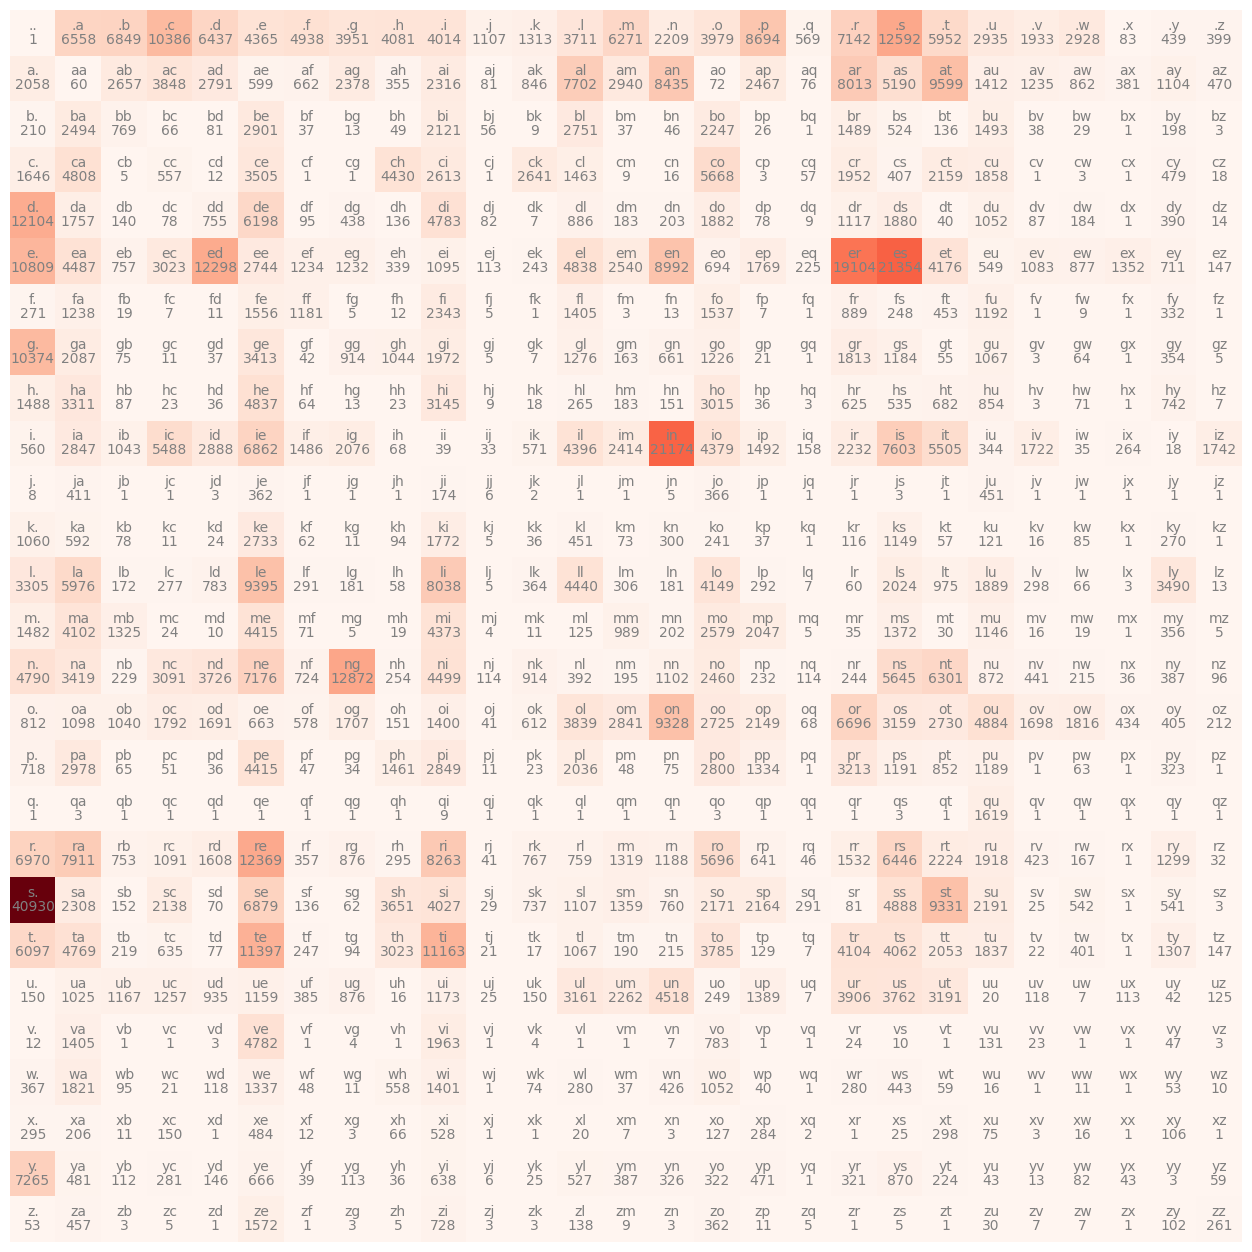

In [4]:
def plot_counts_matrix(counts):
    plt.figure(figsize=(16, 16))
    plt.imshow(counts, cmap="Reds")
    for i in range(27):
        for j in range(27):
            chstr = itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, counts[i, j].item(), ha="center", va="top", color="gray")
    plt.axis("off")


plot_counts_matrix(get_counts_matrix("data/crosswd.txt"))

## <a id='toc3_2_'></a>[Building Probability Matrix](#toc0_)

In [5]:
def get_probability_matrix(filename):
    counts = get_counts_matrix(filename) + 1
    counts += 1  # add one to smooth model and prevent no zero probabilities. Increase to smooth more.
    return counts / counts.sum(axis=1, keepdims=True)  # probability matrix


def generate_string(Pmatrix):
    string = ""
    char = 0  # starting character
    while True:
        char = np.random.choice(27, size=1, p=Pmatrix[char]).item()
        if char == 0:
            break
        else:
            string += itos[char]

    return string

## <a id='toc3_3_'></a>[Generating New Names and Words](#toc0_)

In [6]:
np.random.seed(1234)

Pnamesf = get_probability_matrix("data/names-f.txt")
Pnamesm = get_probability_matrix("data/names-m.txt")
Pcrosswd = get_probability_matrix("data/crosswd.txt")

print(f"female names: {[generate_string(Pnamesf) for i in range(10)]}")
print(f"  male names: {[generate_string(Pnamesm) for i in range(10)]}")
print(f"       words: {[generate_string(Pcrosswd) for i in range(10)]}")

female names: ['cieroleryndenieli', 'osela', 'tierelonnaniathra', 'anel', 'kaiame', 'lvnystelia', 'aey', 'boria', 'she', 'eelvinannggalithelobjoropy']
  male names: ['ar', 'we', 'hus', 'fdsorton', 'chiachesaicy', 'en', 'ty', 'beran', 'wie', 'rroton']
       words: ['rutyoontwiles', 'respponslialoneraes', 'gg', 'styrksmobig', 'boorkengexe', 'ts', 'phahe', 'prteelsth', 'adeal', 'p']


In [7]:
P = Pcrosswd
log_likelihood = 0
nbigrams = 0
for b in get_bigrams_from_file("data/crosswd.txt"):
    i = stoi[b[0]]
    j = stoi[b[1]]
    log_likelihood += np.log(P[i, j])  # log(a*b*c) = log(a) + log(b) + log(c)
    nbigrams += 1

nll = -1 * log_likelihood / nbigrams
print(f"Average negative log likelihood: {nll:.4}")

Average negative log likelihood: 2.498


# <a id='toc4_'></a>[Single Layer Neural Network](#toc0_)

In [8]:
import torch

## <a id='toc4_1_'></a>[Getting Input](#toc0_)

The x's, which are fed into the neural network, need to be one-hot encoded vectors. The y-values do not, and are used for indexing.

In [9]:
def get_xy_from_file(filename):
    xs = []
    ys = []
    for b in get_bigrams_from_file(filename):
        xs.append(stoi[b[0]])
        ys.append(stoi[b[1]])

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    xs = torch.nn.functional.one_hot(xs, num_classes=27).float()

    return xs, ys


g = torch.Generator().manual_seed(1234)
W = torch.randn((27, 27), generator=g, requires_grad=True)  # 27 inputs and 27 neurons
xs, ys = get_xy_from_file("data/crosswd.txt")

## <a id='toc4_2_'></a>[Gradient Descent Algorithm](#toc0_)

The more smoothing (regularization) you do the closer to a uniform distribution you will get when predicting the next value.

In [10]:
for i in range(20):
    # forward pass
    logits = xs @ W  # considered as the the log-counts
    counts = logits.exp()  # this gives a value analogous to counts
    P = counts / counts.sum(1, keepdims=True)

    # loss function
    loss = -P[torch.arange(len(xs)), ys].log().mean()
    loss += 0.01 * (W**2).mean()  # smoothing keeps weights close to zero

    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()

    # update
    W.data += -100 * W.grad

nll = -P[torch.arange(len(xs)), ys].log().mean()
print(f"Average negative log likelihood: {nll:.4}")


Average negative log likelihood: 2.574


## <a id='toc4_3_'></a>[Neural Network Generating Words](#toc0_)

In [11]:
g = torch.Generator().manual_seed(1234)


def generate_string_nn(W):
    string = ""
    char = 0  # starting character
    while True:
        x = torch.nn.functional.one_hot(torch.tensor(char), num_classes=27).float()
        counts = (x @ W).exp()
        p = counts / counts.sum()
        char = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if char == 0:
            break
        else:
            string += itos[char]

    return string


for i in range(10):
    print(generate_string_nn(W))


s
ce
pitd
crifiebivedag
onte
cein
fututedeove
gcs
by
matistrewaresady
